In [1]:
import torch
import time

from torch import optim, nn
from importlib import reload
import numpy as np

import matplotlib.pyplot as plt

In [2]:
def estimate_tensor_size(inp, unit='B'):
    input_size = 0
    if isinstance(inp, torch.Tensor): 
        input_size += float(torch.prod(torch.tensor(inp.size())))
    if isinstance(inp, list): 
        for sub_inp in inp:
            if isinstance(sub_inp, torch.Tensor): input_size += float(torch.prod(torch.tensor(sub_inp.size())))

    input_size = input_size*torch.rand((1,1)).element_size() # multiply by 4
    if unit == 'GB':
        gb_mem = round(input_size/1024**3,8)
        #print("Estimated Input/Output Memory:",gb_mem, "GB")
        return gb_mem
    if unit == 'B':
        gb_mem = input_size
        #print("Estimated Input/Output Memory:",gb_mem, "B")
        return gb_mem
    else:
        mb_mem = round(input_size/1024**2,8)
        #print("Estimated Input/Output Memory:", mb_mem, "MB")
        return mb_mem

In [3]:
start_gpu = 0
end_gpu   = 2
N = 8

batch_size = [1,4,8,16,32,64,128,256,1024,2048,4096, 8192]
comp_size  = [1,1,1, 1, 1, 2,  4,  8,  8,  8, 16, 32]

## Comm time without any compute

In [4]:
d = {}
for n in batch_size:
    #dummy = torch.rand((n*2500,10, 64))
    print(n)
    
    times = []
    for i in range(N):
        dummy = torch.rand((n,300,300))
        dsize = estimate_tensor_size(dummy)
        dummy0 = dummy.to(start_gpu)
        torch.cuda.synchronize(start_gpu);torch.cuda.synchronize(end_gpu);
        
        start = time.time()
        dummy1 = dummy0.to(end_gpu)
        torch.cuda.synchronize(start_gpu);torch.cuda.synchronize(end_gpu);
        end = time.time()
        times.append(1000*(end-start))

    comm_time = np.mean(times[round(N/4):])
    
    del dummy1
    del dummy0
    torch.cuda.empty_cache()
    
    d[dsize] = comm_time

1
4
8
16
32
64
128
256
1024
2048
4096
8192


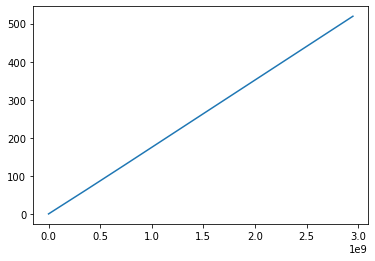

In [5]:
import matplotlib.pylab as plt
lists = sorted(d.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.plot(x, y, '-*')
plt.show()

In [6]:
z = np.polyfit(x, y, 1)
z

array([ 1.76009695e-07, -2.32223659e-01])

### Across all device pairs

In [4]:
gpu_ids = [0,1,2,3]
L = len(gpu_ids)
M = np.zeros((L,L))
C = np.zeros((L,L))


for start_gpu  in gpu_ids:
    for end_gpu in gpu_ids:    
        d = {}
        print("Start GPU:", start_gpu, " | End GPU:", end_gpu)
        for n in batch_size:
            #dummy = torch.rand((n*2500,10, 64))
            print(n)

            times = []
            for i in range(N):
                dummy = torch.rand((n,300,300))
                dsize = estimate_tensor_size(dummy)
                dummy0 = dummy.to(start_gpu)
                torch.cuda.synchronize(start_gpu);torch.cuda.synchronize(end_gpu);

                start = time.time()
                dummy1 = dummy0.to(end_gpu)
                torch.cuda.synchronize(start_gpu);torch.cuda.synchronize(end_gpu);
                end = time.time()
                times.append(1000*(end-start))

            comm_time = np.mean(times[round(N/4):])

            del dummy1
            del dummy0
            torch.cuda.empty_cache()

            d[dsize] = comm_time
            
        lists = sorted(d.items()) # sorted by key, return a list of tuples
        x, y = zip(*lists)       # unpack a list of pairs into two tuples   
        z = np.polyfit(x, y, 1)
        M[start_gpu][end_gpu] = z[0]
        C[start_gpu][end_gpu] = z[1]
        print("m = ", z[0], " | c = ", z[1])
        print("-"*30)

Start GPU: 0  | End GPU: 0
1
4
8
16
32
64
128
256
1024
2048
4096
8192
m =  3.3941669109807436e-12  | c =  0.013692598558502226
------------------------------
Start GPU: 0  | End GPU: 1
1
4
8
16
32
64
128
256
1024
2048
4096
8192
m =  1.737654300986984e-07  | c =  0.032414997576415555
------------------------------
Start GPU: 0  | End GPU: 2
1
4
8
16
32
64
128
256
1024
2048
4096
8192
m =  1.760861748889708e-07  | c =  -0.23902320874077293
------------------------------
Start GPU: 0  | End GPU: 3
1
4
8
16
32
64
128
256
1024
2048
4096
8192
m =  1.7606075971425704e-07  | c =  -0.21338361804331554
------------------------------
Start GPU: 1  | End GPU: 0
1
4
8
16
32
64
128
256
1024
2048
4096
8192
m =  1.7339037312513723e-07  | c =  0.3082001034541081
------------------------------
Start GPU: 1  | End GPU: 1
1
4
8
16
32
64
128
256
1024
2048
4096
8192
m =  4.832507827267787e-12  | c =  0.018464983964587883
------------------------------
Start GPU: 1  | End GPU: 2
1
4
8
16
32
64
128
256
1024
20

In [5]:
print(M)
print(C)

[[3.39416691e-12 1.73765430e-07 1.76086175e-07 1.76060760e-07]
 [1.73390373e-07 4.83250783e-12 1.75996445e-07 1.75953476e-07]
 [1.75912029e-07 1.76086295e-07 3.46248662e-12 1.73816571e-07]
 [1.75994748e-07 1.75970618e-07 1.73777341e-07 3.11809548e-12]]
[[ 0.0136926   0.032415   -0.23902321 -0.21338362]
 [ 0.3082001   0.01846498 -0.22897869 -0.22445373]
 [-0.28877743 -0.26174009  0.01959736  0.00301832]
 [-0.27857338 -0.24525063  0.04731478  0.018854  ]]


## comm time in parallel stream with compute

In [7]:
stream0 = torch.cuda.Stream(device=start_gpu)
stream1 = torch.cuda.Stream(device=end_gpu)

matrixA = torch.rand(5000,5000).to(start_gpu)
matrixB = torch.rand(5000,5000).to(start_gpu)

matrixC = torch.rand(5000,5000).to(end_gpu)
matrixD = torch.rand(5000,5000).to(end_gpu)

In [8]:
######## For profiler #################
from torch.profiler import profile, record_function, ProfilerActivity

In [9]:
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA]) as prof:
#if 1:
    d = {}
    for k in range(len(batch_size)):
        #dummy = torch.rand((n*2500,10, 64))
        print(batch_size[k])

        times = []
        for i in range(N):
            start = torch.cuda.Event(enable_timing=True)
            end = torch.cuda.Event(enable_timing=True)
            
            dummy = torch.rand((batch_size[k],300,300))
            dsize = estimate_tensor_size(dummy)
            dummy0 = dummy.to(start_gpu)
            torch.cuda.synchronize(start_gpu);torch.cuda.synchronize(end_gpu);
            
            for _ in range(comp_size[k]):
                matrixB = torch.matmul(matrixA,matrixB)
            for _ in range(comp_size[k]):
                matrixD = torch.matmul(matrixC,matrixD)

            with torch.cuda.stream(stream0), torch.cuda.stream(stream1):
                start.record()
                dummy1 = dummy0.to(end_gpu)
                end.record()
            torch.cuda.synchronize(start_gpu);torch.cuda.synchronize(end_gpu);

            times.append(start.elapsed_time(end))

        comm_time = np.mean(times[round(N/4):])

        del dummy1
        del dummy0
        torch.cuda.empty_cache()

        d[dsize] = comm_time
        
prof.export_chrome_trace("traces/comm_time.json")

1
4
8
16
32
64
128
256
1024
2048
4096
8192


In [10]:
d

{360000.0: 0.11879466722408931,
 1440000.0: 0.3092426657676697,
 2880000.0: 0.55417600274086,
 5760000.0: 1.0612586537996929,
 11520000.0: 2.045893351236979,
 23040000.0: 4.098229328791301,
 46080000.0: 8.16590404510498,
 92160000.0: 16.168165524800617,
 368640000.0: 64.71069717407227,
 737280000.0: 129.56707255045572,
 1474560000.0: 260.3871815999349,
 2949120000.0: 522.0422973632812}

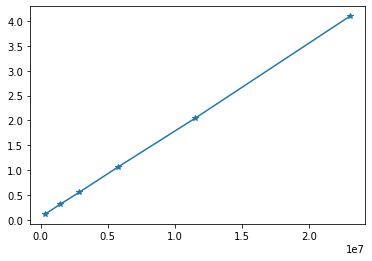

In [17]:
import matplotlib.pylab as plt
lists = sorted(d.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.plot(x[:5], y[:5], '-*')
plt.show()

In [12]:
z = np.polyfit(x, y, 1)
z

array([ 1.76917511e-07, -1.22709839e-01])

In [13]:
d

{360000.0: 0.11879466722408931,
 1440000.0: 0.3092426657676697,
 2880000.0: 0.55417600274086,
 5760000.0: 1.0612586537996929,
 11520000.0: 2.045893351236979,
 23040000.0: 4.098229328791301,
 46080000.0: 8.16590404510498,
 92160000.0: 16.168165524800617,
 368640000.0: 64.71069717407227,
 737280000.0: 129.56707255045572,
 1474560000.0: 260.3871815999349,
 2949120000.0: 522.0422973632812}

In [14]:
'''
Conclusion: Running compute in parallel with communication stream doesn't afffect comm -time

'''

"\nConclusion: Running compute in parallel with communication stream doesn't afffect comm -time\n\n"